In [1]:
import os
import torch
import numpy as np
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as T
import torch.nn.functional as F

from ig_pkg.datasets import get_datasets

from ig_pkg.models.generator import get_model
from ig_pkg.models.classifier import get_classifier
from ig_pkg.models.pretrained_models import get_pretrained_model

from ig_pkg.inputattribs.ig import make_interpolation, ig
from ig_pkg.inputattribs.baseline_generator import get_baseline_generator

from ig_pkg.misc import process_heatmap, normalize_tensor, convert_to_img, label_to_class, tran, na_imshow

import time
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from ig_pkg.loss.focal_loss import FocalLoss
from ig_pkg.loss.metrics import ArcMarginProduct, AddMarginProduct

import torchvision.models as models
from torch.autograd import Variable


IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))


In [41]:
# https://github.com/PAIR-code/saliency/blob/master/Examples_pytorch.ipynb

import saliency.core as saliency

# Boilerplate methods.
def ShowImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im)
    plt.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.title(title)

def ShowHeatMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap='inferno')
    P.title(title)

transformer = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean = IMAGENET_MEAN, std = IMAGENET_STD),
])

def LoadNumpy(file_path):
    im = Image.open(file_path)
    im = im.resize((224, 224)) # reserve channel 
    im = np.asarray(im)
    return im    

# def PreprocessImages(images):
#     # assumes input is 4-D, with range [0,255]
#     #
#     # torchvision have color channel as first dimension
#     # with normalization relative to mean/std of ImageNet:
#     #    https://pytorch.org/vision/stable/models.html
#     images = np.array(images)
#     images = images/255
#     images = np.transpose(images, (0,3,1,2))
#     images = torch.tensor(images, dtype=torch.float32)
#     images = transformer.forward(images)
#     return images.requires_grad_(True)

def LoadTensor(file_path):
    im = Image.open(file_path)
    temp = np.asarray(im)
    if len(temp.shape) == 3: images = transformer(im)    
    else: return 0
    return images.requires_grad_(True)

In [25]:
# model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
# eval_mode = model.eval()

model = models.resnet18(pretrained=False)
save_path = f'/root/pretrained/imagenet_val.pth'
model.load_state_dict(torch.load(save_path))
eval_mode = model.eval()


/root/dh/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/dh/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
# n02443484: 40 black-footed_ferret
# n01614925: 398 bald_eagle

data_path="/root/data/ILSVRC2012_val/"

ferrot_dir = os.path.join(data_path, 'val', 'n02443484')
ferrot_idx = os.listdir(ferrot_dir)[0]
ferrot_np = LoadNumpy(os.path.join(ferrot_dir, ferrot_idx))
ferrot_tensor = LoadTensor(os.path.join(ferrot_dir, ferrot_idx))

eagle_dir = os.path.join(data_path, 'val', 'n01614925')
eagle_idx = os.listdir(eagle_dir)[1]
eagle_img = LoadNumpy(os.path.join(eagle_dir, eagle_idx))
eagle_tensor = LoadTensor(os.path.join(eagle_dir, eagle_idx))


In [12]:
class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    images = PreprocessImages(images)
    target_class_idx =  call_model_args[class_idx_str]
    output = model(images)
    m = torch.nn.Softmax(dim=1)
    output = m(output)
    if saliency.base.INPUT_OUTPUT_GRADIENTS in expected_keys:
        outputs = output[:,target_class_idx]
        grads = torch.autograd.grad(outputs, images, grad_outputs=torch.ones_like(outputs))
        grads = torch.movedim(grads[0], 1, 3)
        gradients = grads.detach().numpy()
        return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
    else:
        one_hot = torch.zeros_like(output)
        one_hot[:,target_class_idx] = 1
        model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)
        return conv_layer_outputs

In [6]:
predictions = eval_mode(ferrot_tensor.unsqueeze(0))
predictions = predictions.detach().numpy()
prediction_class = np.argmax(predictions[0])
# call_model_args = {class_idx_str: prediction_class}

# print("Prediction class: " + str(prediction_class))  # Should be a doberman, class idx = 236
# im = ferrot_img.astype(np.float32)
print(prediction_class)

358


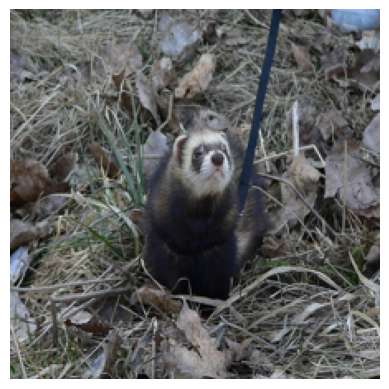

In [10]:
ShowImage(ferrot_np)

In [45]:
ferrot_dir = os.path.join(data_path, 'val', 'n02443484')
ferrot_list = os.listdir(ferrot_dir)
ferrot_list = [file for file in ferrot_list if file.endswith(".JPEG")]

for i in range(len(ferrot_list)):
#     print(ferrot_list[i])
    path = os.path.join(ferrot_dir, ferrot_list[i])
    img = LoadTensor(path) 
    if img:
        img = img.unsqueeze(0)    
    
        if i == 0:
            ferrot = img#.unsqueeze(0)
        else: 
            ferrot = torch.vstack((ferrot, img))

#     print(img.shape, ferrot.shape)


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [26]:
score = eval_mode(ferrot)
print(score.shape)
idx = torch.argmax(score, dim = -1)
print(idx.shape)

torch.Size([9, 1000])
torch.Size([9])


In [28]:
os.listdir(ferrot_dir)

['ILSVRC2012_val_00048131.JPEG',
 'ILSVRC2012_val_00016084.JPEG',
 'ILSVRC2012_val_00032951.JPEG',
 'ILSVRC2012_val_00012685.JPEG',
 'ILSVRC2012_val_00036439.JPEG',
 'ILSVRC2012_val_00014233.JPEG',
 'ILSVRC2012_val_00042850.JPEG',
 'ILSVRC2012_val_00036771.JPEG',
 'ILSVRC2012_val_00036425.JPEG',
 'ILSVRC2012_val_00018383.JPEG',
 'ILSVRC2012_val_00000401.JPEG',
 'ILSVRC2012_val_00023673.JPEG',
 'ILSVRC2012_val_00031517.JPEG',
 'ILSVRC2012_val_00011092.JPEG',
 'ILSVRC2012_val_00014852.JPEG',
 'ILSVRC2012_val_00047800.JPEG',
 'ILSVRC2012_val_00047022.JPEG',
 'ILSVRC2012_val_00041818.JPEG',
 'ILSVRC2012_val_00027914.JPEG',
 'ILSVRC2012_val_00001909.JPEG',
 'ILSVRC2012_val_00013240.JPEG',
 'ILSVRC2012_val_00040766.JPEG',
 'ILSVRC2012_val_00043098.JPEG',
 'ILSVRC2012_val_00012000.JPEG',
 'ILSVRC2012_val_00000480.JPEG',
 'ILSVRC2012_val_00040895.JPEG',
 'ILSVRC2012_val_00044484.JPEG',
 'ILSVRC2012_val_00032457.JPEG',
 'ILSVRC2012_val_00040026.JPEG',
 'ILSVRC2012_val_00043276.JPEG',
 'ILSVRC20

In [32]:
te = Image.open(os.path.join(ferrot_dir,'ILSVRC2012_val_00018383.JPEG'))




In [40]:
te1 = np.asarray(te)
# print(te1.shape)
len(te1.shape)


2